# Restaurant Demo

PyDP version for Google's Java Differential Privacy Library example - https://github.com/google/differential-privacy/tree/master/examples/java.

Imagine a fictional restaurant owner named Alice who would like to share business statistics with her visitors. Alice knows when visitors enter the restaurant and how much time and money they spend there. To ensure that visitors' privacy is preserved, Alice decides to use the **Differential Privacy library**.

## Initial Setup

In [1]:
# Install the PyDP package
! pip install python-dp

In [1]:
import pydp as dp # by convention our package is to be imported as dp (for Differential Privacy!)
import pandas as pd
import statistics # for calculating mean without applying differential privacy
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import math
print("Setup Complete")

Setup Complete


## Count visits by hour of day

In this example Alice wants to share this information with potential clients in order **to let them know the busiest times in the restaurant**. For this, we will ***count how many visitors enter the restaurant at every hour of a particular day***. For simplicity, assume that a visitor comes to the restaurant at most once a day. In other words, a visitor is present at most once in the whole dataset.

Visit data for a single day is stored in the **day_data.csv** file. It includes the visitor’s ID, the visit duration (in minutes), and the money spent at the restaurant.

In [2]:
url = 'https://raw.githubusercontent.com/google/differential-privacy/master/examples/java/day_data.csv'
df = pd.read_csv(url,sep=",")
df.head()

,VisitorId,Time entered,Time spent (mins),Money spent (euros),Day
0,1,9:30:00 AM,26,24,1
1,2,11:39:00 AM,31,18,1
2,3,9:11:00 AM,46,22,1
3,4,11:37:00 AM,41,25,1
4,5,10:59:00 AM,25,16,1


We want to read the daily statistics and calculate the number of *visitors* that entered the restaurant *every hour* of the day. 

In [3]:
# Get the Visitor and time entered data into new DataFrame 
cols = ['VisitorId', 'Time entered']
new_df = df.loc[: , cols]
new_df.head()

,VisitorId,Time entered
0,1,9:30:00 AM
1,2,11:39:00 AM
2,3,9:11:00 AM
3,4,11:37:00 AM
4,5,10:59:00 AM


In [4]:
# check sample data
time = df.iloc[421,1]
time

'8:09:00 PM'

In [5]:
# function to convert time to 24 hrs format 
def convertTo24Hour(date) :
    dateInfo = date.split(' ')     #  ['8:09:00', 'PM']
    dateArr = dateInfo[0].split(':')  # ['8', '09', '00']
    hour = 0
    # for midnight
    if ((dateInfo[1] == 'AM') and (dateArr[0] == '12')):
        hour = 0
    # for 12 noon
    elif ((dateInfo[1] == 'PM') and (dateArr[0] == '12')):
        hour = 12
    # for AM and PM
    elif (dateInfo[1] == 'AM') :
        hour = int(dateArr[0])
    else:
        hour = int(dateArr[0]) + 12
    return hour

# It works as we planned it to be!
hour24 = convertTo24Hour('1:23:34 PM')
print(hour24)

13


In [6]:
# Now create a new column called partition with hour data in the new_df
partition = []

for time in df['Time entered']:   # convert timings into 24hrs format
    new = convertTo24Hour(time)
    partition.append(new)

    
new_df['Partition'] = partition  # add new column
new_df.tail()


,VisitorId,Time entered,Partition
445,446,8:10:00 PM,20
446,447,7:32:00 PM,19
447,448,7:50:00 PM,19
448,449,8:22:00 PM,20
449,450,7:22:00 PM,19


#### Restaurant Schedule

In [7]:
# An hour when visitors start entering the restaurant.
OPENING_HOUR = 9

#An hour when visitors stop entering the restaurant.
CLOSING_HOUR = 20

# For how many hours visitors can enter the restaurant.
NUM_OF_WORK_HOURS = CLOSING_HOUR - OPENING_HOUR + 1      # 12

# Range of valid work hours when a visitor can enter the restaurant.
VALID_HOURS = list(range(OPENING_HOUR, CLOSING_HOUR+1))  # [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

### Explanation
#### Partitions and contributions
We say that the resulting aggregated data is split into partitions. The bar chart for the private and non-private counts each have 12 partitions, one for each entry hour.

More generally, a single partition represents a subset of aggregated data corresponding to a given value of the aggregation criterion. Graphically, a single partition is represented as a bar on the aggregated bar chart.

We say that a visitor contributes to a given partition if their data matches the partition criterion. For example, if a visitor enters between 8 AM and 9 AM, they contribute to the 8 AM partition.

Recall that in the the example above, a visitor can enter the restaurant only once per day. This implies three contribution bounds:

- **Maximum partitions contributed**: to how many partitions can a visitor contribute? In our example, a visitor can contribute up to one partition. In other words, there is at most one time-slot when a visitor with a given id can enter the restaurant.
- **Maximum contributed value**: what is the maximum value that can be contributed by a visitor to a partition? In our example, we count the number of visits, so the maximum contributed value is simply 1.
- **Maximum contributions per partition**: how many times can a visitor contribute to a partition? In our example, a visitor can contribute to a partition at most once. In other words, a visitor can enter the restaurant only once at a given hour.

Why is this important? Differential Privacy adjusts the amount of noise to mask contributions of each visitor. More contributions require more noise.

In [8]:
# visitor contributes to a given partitions VALID_HOURS 
# In the given data 1 visitor contributes to only one partition as suggested by 'Maximum contributions per partition'

# Count the no of visitors per hour
count = new_df.groupby('Partition').VisitorId.count() # gives a series 
count

Partition
9     13
10    18
11    19
12    39
13    61
14    21
15    14
16    15
17    48
18    52
19    78
20    72
Name: VisitorId, dtype: int64

In [9]:
# convert series to list
CountPerHour = list(count)
print(CountPerHour)

[13, 18, 19, 39, 61, 21, 14, 15, 48, 52, 78, 72]


Text(0,0.5,'Visitors')

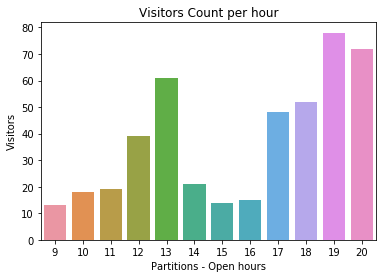

In [10]:
#plot bar chart
#labels, y = zip(*CountPerHour)
x= VALID_HOURS
y = CountPerHour
sns.barplot(x= x , y=y)

plt.title("Visitors Count per hour")
plt.xlabel("Partitions - Open hours")
plt.ylabel("Visitors")

### Note: The data preprocessing is done by the user, the library PyDP only helps with introducing noise to the data and making it differentially private

In [11]:
data= new_df.groupby('Partition').VisitorId.apply(list)  #converting series to list
data_list= list(data)


In [12]:
type(data_list)

list

In [13]:
# Private Count visits by hour of day
PrivateCountPerHour = []
LN_3 = math.log(3)

def cal_private_count(privacy_budget: float):
    for data in data_list:
        x = dp.CountInt(privacy_budget)        
        count = x.result(data)      # accepts list as input
        PrivateCountPerHour.append(count)
    return PrivateCountPerHour

cal_private_count(LN_3)
print(PrivateCountPerHour)
    
    


[13, 20, 21, 39, 63, 22, 14, 15, 48, 53, 78, 72]


Text(0,0.5,'Visitors')

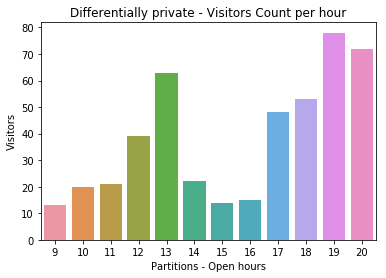

In [14]:
#plot bar chart

x= VALID_HOURS
y = PrivateCountPerHour
sns.barplot(x= x , y=y)

plt.title("Differentially private - Visitors Count per hour")
plt.xlabel("Partitions - Open hours")
plt.ylabel("Visitors")

The image below illustrates the results. The blue (left) bars represent the counts without anonymization while yellow (right) bars correspond to the private (or anonymized) counts. You can see that the private values slightly differ from the actual ones but the overall trend is preserved. For example, you can clearly see that the restaurant is more busy during lunch and dinner time.

In [15]:
# function to compare graphs
def comparison_graph(labels, x1, x2, rect1_label, rect2_label, x_label, title):
    x = np.arange(len(labels))  # the label locations
    width = 0.34  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(14,6))
    rects1 = ax.bar(x - width/2, x1, width, label= rect1_label)
    rects2 = ax.bar(x + width/2, x2, width, label= rect2_label)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(x_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0,5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()  
   

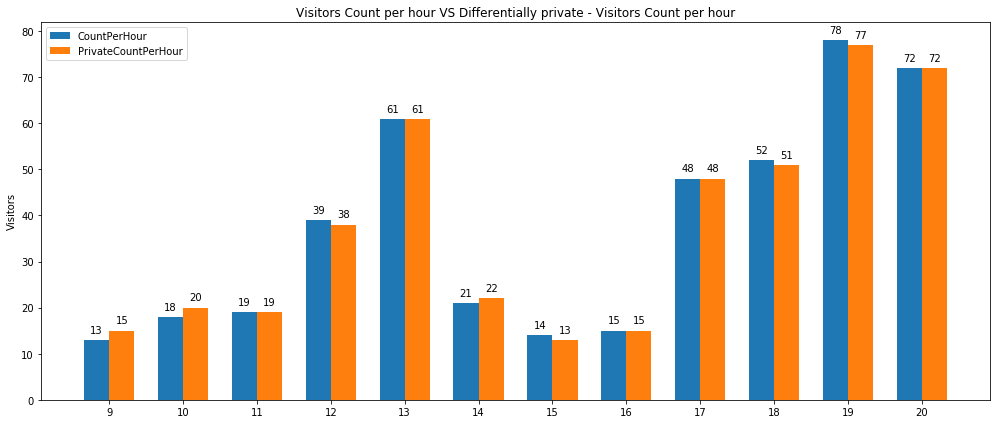

In [16]:
# compare the results
labels = VALID_HOURS
x1 = CountPerHour
x2 = PrivateCountPerHour

comparison_graph(labels, x1, x2, 'CountPerHour', 'PrivateCountPerHour', 'Visitors','Visitors Count per hour VS Differentially private - Visitors Count per hour'  )


Note that Differential Privacy involves adding random noise to the actual data, so your results will most likely be slightly different.

 Next, we will demonstrate how to use the library in scenarios where: 

- Visitors can contribute to multiple partitions.
- Contributed values can be greater than 1.
- Visitors can contribute to a partition multiple times.

## Count visits by day of week

The previous example made some over-simplifying assumptions. Now, let’s have a look at the use-case where visitors can contribute to multiple partitions.

Imagine Alice decides to let visitors know which days are the busiest at her restaurant. For this, she calculates how many people visit the restaurant every day of the week. For simplicity, let’s assume a visitor enters the restaurant at most once a day but multiple times a week.

Visit data for a week is stored in the **week_data.csv** file.

- *Case 1* -  once a day - multiple times a week 
- *Case 2* - once a day - max three times a week

Speaking in terms of partitions and contributions, the resulting bar chart has 7 partitions: one for each day of the week. A visitor may enter the restaurant once a day and hence contribute to a partition at most once. A visitor may enter the restaurant several times a week and hence contribute to up to 7 partitions.

In [16]:
url = 'https://raw.githubusercontent.com/google/differential-privacy/master/examples/java/week_data.csv'
visitor_df = pd.read_csv(url,sep=",")
visitor_df.head()

,VisitorId,Time entered,Time spent (minutes),Money spent (euros),Day
0,580,9:27:00 AM,29,17,1
1,1215,9:16:00 AM,45,18,1
2,448,11:55:00 AM,12,16,1
3,125,10:47:00 AM,27,20,1
4,484,11:08:00 AM,35,13,1


In [17]:
# check the data
visitor_df[["VisitorId","Day"]].head()

,VisitorId,Day
0,580,1
1,1215,1
2,448,1
3,125,1
4,484,1


In [18]:
# Day for index - check 
print(visitor_df.loc[2849,"Day"])

7


In [19]:
#view and check 
#Visitors in Day -1 
day1 = visitor_df.loc[visitor_df["Day"] == 1]
print(day1)

# Search Visitor ID details
visitor= visitor_df.loc[visitor_df["VisitorId"] == 1215]
print(visitor)

# Count number of days visit per week > 3
print(visitor["Day"].count() > 3)

# combining the two - vsist count > 3 per week
print(visitor_df.loc[visitor_df["VisitorId"] == 1215]["Day"].count() > 3)

# days of visit
visitor_day= visitor_df.loc[visitor_df["VisitorId"] == 1215]["Day"]
print(visitor_day)

     VisitorId Time entered  Time spent (minutes)  Money spent (euros)  Day
0          580   9:27:00 AM                    29                   17    1
1         1215   9:16:00 AM                    45                   18    1
2          448  11:55:00 AM                    12                   16    1
3          125  10:47:00 AM                    27                   20    1
4          484  11:08:00 AM                    35                   13    1
5          514   9:11:00 AM                    34                   18    1
6          346   9:51:00 AM                    55                   25    1
7          326   9:35:00 AM                    49                   19    1
8          527  10:59:00 AM                    38                   30    1
9          180  10:57:00 AM                    51                   14    1
10         696   9:36:00 AM                    29                   19    1
11        1224   9:18:00 AM                    30                   18    1
12        10

In [20]:
day = [ {"Day_"+str(i) : 0} for i in visitor_df["Day"].unique()]
print(day)

days = [ "Day_"+str(i)  for i in visitor_df["Day"].unique() ]
print(days)

days_int = [ i for i in visitor_df["Day"].unique() ]
print(days_int)

[{'Day_1': 0}, {'Day_2': 0}, {'Day_3': 0}, {'Day_4': 0}, {'Day_5': 0}, {'Day_6': 0}, {'Day_7': 0}]
['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
[1, 2, 3, 4, 5, 6, 7]


In [21]:
# Another DataFrame for maxPartitionsContributed per day
visitor_count_df = pd.DataFrame( {'VisitorId' : visitor_df["VisitorId"].unique()})
#print(visitor_count)

# Set all Days visit to 0 and Count_perWeek (<= 3) to False
def resetVisitorCount():
    for i in days:
        visitor_count_df[i] = 0
        
    visitor_count_df["Count_perWeek"] = False
    return visitor_count_df
    
resetVisitorCount().head()

#print(visitor_count_df)

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,0,0,0,0,0,0,0,False
1,1215,0,0,0,0,0,0,0,False
2,448,0,0,0,0,0,0,0,False
3,125,0,0,0,0,0,0,0,False
4,484,0,0,0,0,0,0,0,False


In [22]:
# Add Per Day visit to visitor_count_df
# 1 - present , 0 - absent

def perDayVisits():
    for index_no in visitor_df.index:
        day_no = visitor_df.loc[index_no,'Day']
        id_no = visitor_df.loc[index_no,'VisitorId']
        #index_val = visitor_df.loc[visitor_df["VisitorId"] == id_no].index[0]
        #print("index val : ",index_val, "day_no :", day_no)
        
        #in visitor_count_df dataframe
        visitor_index_val = visitor_count_df.loc[visitor_count_df["VisitorId"] == id_no].index[0]
        #print("New index val : ",visitor_index_val)
        visitor_day_val = visitor_count_df.loc[visitor_index_val, "Day_"+str(day_no)]
        #print("Day val : ",visitor_day_val)
        visitor_count_df.at[visitor_index_val, "Day_"+str(day_no) ] = visitor_day_val + 1
        
    return visitor_count_df
        
perDayVisits().head()  
    

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,1,1,1,0,1,0,1,False
1,1215,1,1,0,0,0,1,1,False
2,448,1,1,0,0,0,0,0,False
3,125,1,1,1,1,1,0,0,False
4,484,1,0,0,0,0,0,0,False


In [23]:
visitor_df.loc[visitor_df['VisitorId']== 1251]['Day']

886     3
2349    6
Name: Day, dtype: int64

In [24]:
# verifying the results for perDayVisits()
visitor_count_df.loc[visitor_count_df['VisitorId']== 1251]

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
721,1251,0,0,1,0,0,1,0,False


In [25]:
visitor_count_df.loc[visitor_count_df['Count_perWeek']==True]['Day_5']

Series([], Name: Day_5, dtype: int64)

**Bounding the number of contributed partitions**

The parameter maxPartitionsContributed defines the maximum number of partitions a visitor may contribute to. You might notice that the value of maxPartitionsContributed in our example is 3 instead of 7. Why is that? Differential Privacy adds some amount of random noise to hide contributions of an individual. The more contributions an individual has, the larger the noise is. This affects the utility of the data. In order to preserve the data utility, we made an approximate estimate of how many times a week a person may visit a restaurant on average, and assumed that the value is around 3 instead of scaling the noise by the factor of 7.

We also pre-processed the input data and discarded all exceeding visits. The preprocessing is done by CountVisitsPerDay.boundVisits(....). It is important to keep in mind that the library allows you to specify maximum amount of contributions, but doesn't validate that it is respected.


## Case 2 : Max contribution per week set to 3 times a week

In [26]:
# Check the visitors with greater than Max Contribution and mark as False
def maxPartitionsContributed(MaxNoOfDays: int): 
    for index_no in visitor_count_df.index:
        day_count = 0
        for day_no in days_int:
            if (visitor_count_df.loc[index_no, "Day_"+str(day_no)] > 0 ):
                day_count = day_count + 1
        # check whether day count is > MaxNoOfDays or not
        if day_count <= MaxNoOfDays:
            visitor_count_df.at[index_no, "Count_perWeek"] = True           
    return visitor_count_df

maxPartitionsContributed(3).head() 
    

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,1,1,1,0,1,0,1,False
1,1215,1,1,0,0,0,1,1,False
2,448,1,1,0,0,0,0,0,True
3,125,1,1,1,1,1,0,0,False
4,484,1,0,0,0,0,0,0,True


In [27]:
# create a copy for visitors_Maxweek DataFrame
visitors_Maxweek = visitor_count_df.copy()
visitors_Maxweek.head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,1,1,1,0,1,0,1,False
1,1215,1,1,0,0,0,1,1,False
2,448,1,1,0,0,0,0,0,True
3,125,1,1,1,1,1,0,0,False
4,484,1,0,0,0,0,0,0,True


In [28]:
# check index
visitors_Maxweek.loc[visitor_count_df["Count_perWeek"] == False].index 

Int64Index([   0,    1,    3,    5,    9,   11,   14,   15,   16,   20,
            ...
             781,  789,  803,  828,  845,  896,  952,  955,  981, 1000],
           dtype='int64', length=132)

In [29]:
# If Max contribution is greater than the desired value here 3, then, 
# remove the extra contributions from that visitors per day of week
# set the count_perWeek to true after the extra value has been removed
#This might introduce some bias as when max_contribution = 3, the first 3 days will remain mostly unchanged 
# Day_4 to Day_7 count values will be effected the most.
# But, for simplicity we will go ahead with this approach.

def removeExtraContributions(max_contribution: int):
    
    for index_no in visitors_Maxweek.loc[visitors_Maxweek["Count_perWeek"] == False].index:
        day_count = 0
        for day_no in days_int:
            if (visitors_Maxweek.loc[index_no, "Day_"+str(day_no)] > 0 ):
                day_count = day_count + 1
                
            if day_count > max_contribution:
                visitors_Maxweek.at[index_no, "Day_"+str(day_no)] = 0
                
        visitors_Maxweek.at[index_no, "Count_perWeek"] = True
            
    return visitors_Maxweek

removeExtraContributions(3).head()
    

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,1,1,1,0,0,0,0,True
1,1215,1,1,0,0,0,1,0,True
2,448,1,1,0,0,0,0,0,True
3,125,1,1,1,0,0,0,0,True
4,484,1,0,0,0,0,0,0,True


## Day wise count for both the cases

In [39]:
# Calculate the day wise count for both the cases
print(days)    
total_visitors_max3days = [] # case 2 
total_visitors_day = []      # case 1

for i in days:
    total_visitors_max3days.append(visitors_Maxweek.loc[visitors_Maxweek[i] > 0][i].count())  # case 2
    total_visitors_day.append(visitor_count_df.loc[visitor_count_df[i] > 0][i].count())       # case 1
    
print(total_visitors_max3days)    
print(total_visitors_day)

['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
[300, 300, 400, 394, 432, 460, 407]
[300, 300, 400, 400, 450, 500, 500]


Text(0,0.5,'Visitors')

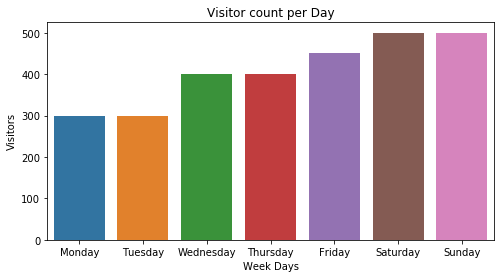

In [31]:
#Bar plot

# Set width and height
plt.figure(figsize = (8,4))
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.barplot(x = x, y = total_visitors_day)
# Add title
plt.title("Visitor count per Day")
plt.xlabel("Week Days")
plt.ylabel("Visitors")



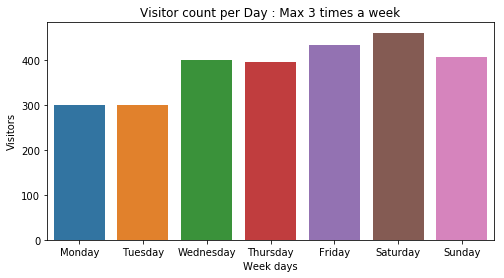

In [32]:
#Bar plot

# Set width and height
plt.figure(figsize = (8,4))
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Add title
plt.title("Visitor count per Day : Max 3 times a week")
plt.xlabel("Week days")
plt.ylabel("Visitors")

sns.barplot(x = x , y = total_visitors_max3days)

# Private Count for the above 2 cases using PyDP library

In [33]:
def cal_private_count_per_day(privacy_budget: float, data_list: list):
    private_count = []
    for data in data_list:
        x = dp.CountInt(privacy_budget)        
        count = x.result(data)
        private_count.append(count)
    return private_count

In [34]:
a = []  #list for case 1
b = []  # list for case 2
new_visitor_count_df = visitor_count_df.copy() #copy by value of DataFrame

for i in days:
    # Case 1: List for 7 days a week
    total_visitors_day = new_visitor_count_df.loc[visitor_count_df[i] > 0][i]
    listForDaysAweek = list(total_visitors_day)
    a.append(listForDaysAweek)
    # Case 2: List for Max 3 days a week
    total_visitors_3week = visitors_Maxweek.loc[visitors_Maxweek[i] > 0][i]
    listForMax3DaysAweek= list(total_visitors_3week)
    b.append(listForMax3DaysAweek)

In [35]:
# caluculate the private count 
    
private_count_perDay_week = cal_private_count_per_day(LN_3, a)
private_count_max3Day_week = cal_private_count_per_day(LN_3, b)

print(days) 
print("Case 1: Private Count per day in a week")
print(private_count_perDay_week)
print("Case 2: Private Count Max 3 days in a week")
print(private_count_max3Day_week)

['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
Case 1: Private Count per day in a week
[300, 300, 400, 400, 447, 500, 501]
Case 2: Private Count Max 3 days in a week
[298, 299, 399, 392, 432, 458, 407]


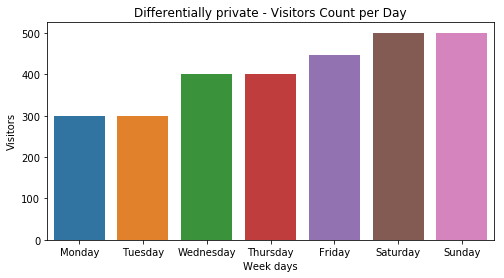

In [36]:
# Case 1 
# Bar Plot

# Set width and height
plt.figure(figsize = (8,4))
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Add title
plt.title("Differentially private - Visitors Count per Day")
plt.xlabel("Week days")
plt.ylabel("Visitors")

sns.barplot(x = x , y = private_count_perDay_week)

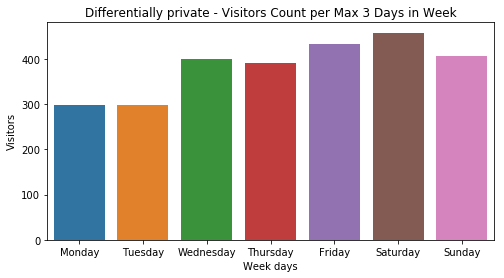

In [37]:
# Case 2
# Bar Plot

# Set width and height
plt.figure(figsize = (8,4))
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Add title
plt.title("Differentially private - Visitors Count per Max 3 Days in Week")
plt.xlabel("Week days")
plt.ylabel("Visitors")

sns.barplot(x = x , y = private_count_max3Day_week)

# Comparison between private and non-private count

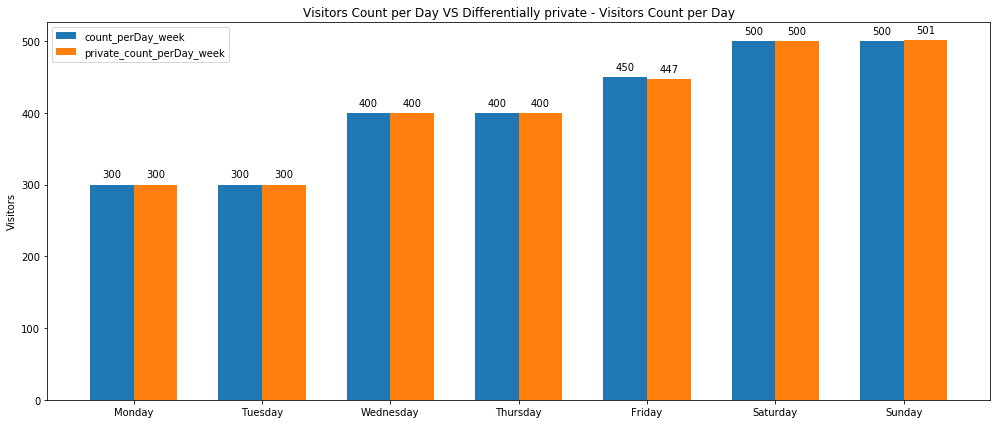

In [40]:
#Case 1 Comparison 
# if error occurs loading - reload total_visitors_day cell above
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x1 = total_visitors_day
x2 = private_count_perDay_week

comparison_graph(labels, x1, x2, 'count_perDay_week', 'private_count_perDay_week', 'Visitors','Visitors Count per Day VS Differentially private - Visitors Count per Day'  )


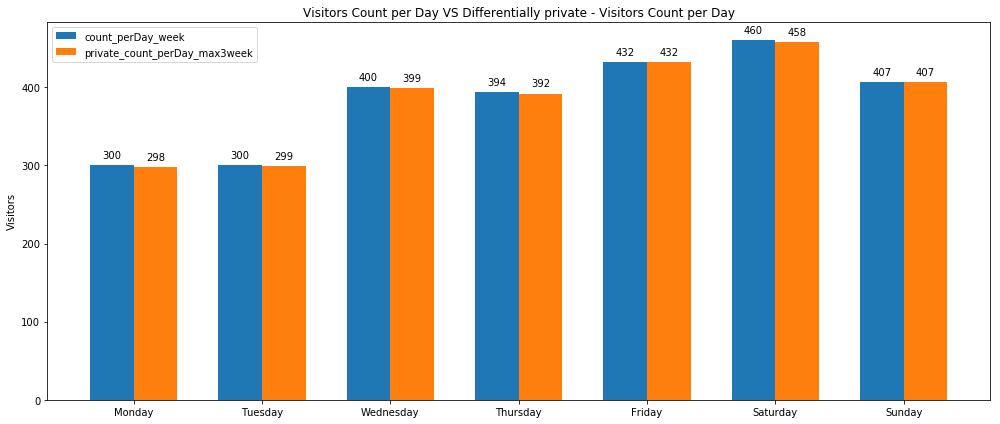

In [41]:
#Case 2 Comparison 
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x1 = total_visitors_max3days
x2 = private_count_max3Day_week

comparison_graph(labels, x1, x2, 'count_perDay_week', 'private_count_perDay_max3week', 'Visitors','Visitors Count per Day VS Differentially private - Visitors Count per Day'  )


## Sum-up revenue per day of the week

The previous example demonstrates how the contributed partitions are bounded. Now, we will demonstrate how individual contributions are clamped. Imagine Alice decides to calculate the sum of the restaurant revenue per week day in a differentially private way. For this she needs to sum up the visitors’ daily spending at the restaurant. For simplicity, let’s assume a visitor enters the restaurant at most once a day but multiple times a week.

In [42]:
# MAX_CONTRIBUTED_DAYS = 4
MIN_EUROS_SPENT = 0

MAX_EUROS_SPENT = 50

epsilon = math.log(3)

In [43]:
revenue_visitor_df = visitor_df[["VisitorId","Day","Money spent (euros)"]]
revenue_visitor_df.head()

,VisitorId,Day,Money spent (euros)
0,580,1,17
1,1215,1,18
2,448,1,16
3,125,1,20
4,484,1,13


In [44]:
resetVisitorCount().head() # returns visitor_count_df reset days values to 0

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,0,0,0,0,0,0,0,False
1,1215,0,0,0,0,0,0,0,False
2,448,0,0,0,0,0,0,0,False
3,125,0,0,0,0,0,0,0,False
4,484,0,0,0,0,0,0,0,False


In [45]:
perDayVisits().head() # returns visitor_count_df days values - 1 -> present 0 -> absent

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,1,1,1,0,1,0,1,False
1,1215,1,1,0,0,0,1,1,False
2,448,1,1,0,0,0,0,0,False
3,125,1,1,1,1,1,0,0,False
4,484,1,0,0,0,0,0,0,False


In [46]:
# Add Per Day Amount to visitor_count_df
# Replace the Day attendance with the amount spent on that day

def perDayAmount():
    for index_no in visitor_df.index:
        day_no = visitor_df.loc[index_no,'Day']
        id_no = visitor_df.loc[index_no,'VisitorId']
        amount = visitor_df.loc[index_no,'Money spent (euros)']
        #index_val = visitor_df.loc[visitor_df["VisitorId"] == id_no].index[0]
        #print("index val : ",index_val, "day_no :", day_no)
        
        #other dataframe
        visitor_index_val = visitor_count_df.loc[visitor_count_df["VisitorId"] == id_no].index[0]
        #print("New index val : ",visitor_index_val)
        visitor_day_val = visitor_count_df.loc[visitor_index_val, "Day_"+str(day_no)]
        #print("Day val : ",visitor_day_val)
        visitor_count_df.at[visitor_index_val, "Day_"+str(day_no) ] = amount
        
    return visitor_count_df
        
perDayAmount().head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,17,32,23,0,26,0,29,False
1,1215,18,28,0,0,0,36,22,False
2,448,16,35,0,0,0,0,0,False
3,125,20,47,24,26,20,0,0,False
4,484,13,0,0,0,0,0,0,False


In [47]:
maxPartitionsContributed(4).head()  # returns visitor_count_df with True and False values for max contribution = 4

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,17,32,23,0,26,0,29,False
1,1215,18,28,0,0,0,36,22,True
2,448,16,35,0,0,0,0,0,True
3,125,20,47,24,26,20,0,0,False
4,484,13,0,0,0,0,0,0,True


In [48]:
# create a copy for visitors_Maxweek DataFrame  
# Just as we did in the above two cases
visitors_Maxweek = visitor_count_df.copy()
visitors_Maxweek.head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,17,32,23,0,26,0,29,False
1,1215,18,28,0,0,0,36,22,True
2,448,16,35,0,0,0,0,0,True
3,125,20,47,24,26,20,0,0,False
4,484,13,0,0,0,0,0,0,True


In [49]:
# Remove extra contribution from visitors_Maxweek DataFrame 
# returns visitors_Maxweek
removeExtraContributions(4).head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Count_perWeek
0,580,17,32,23,0,26,0,0,True
1,1215,18,28,0,0,0,36,22,True
2,448,16,35,0,0,0,0,0,True
3,125,20,47,24,26,0,0,0,True
4,484,13,0,0,0,0,0,0,True


In [50]:
# Calculate per day amount - Unbounded sum

perDayAmount=[]

for day in days:  # day = day_1
    amount = visitors_Maxweek.loc[:, day ].sum()
    perDayAmount.append(amount)
    

print(days)
print(perDayAmount)

['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
[8678, 8696, 12088, 12079, 13682, 16311, 16082]


In [51]:
# Calculate the Bounded Amount per week  MAX_EUROS_SPENT = 50 
perDayAmountBounded = []
for day in days:

    AmountBounded = []
    
    for index_no in visitors_Maxweek.index:
        amount = visitors_Maxweek.loc[index_no, day]
        
        if amount > MAX_EUROS_SPENT:
            amount = MAX_EUROS_SPENT
            
        if amount != 0:
            AmountBounded.append(amount)
            
    total = sum(AmountBounded)
    perDayAmountBounded.append(total)
    
print(days)
print(perDayAmountBounded)    

['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
[8642, 8696, 11998, 12054, 13682, 16311, 16082]


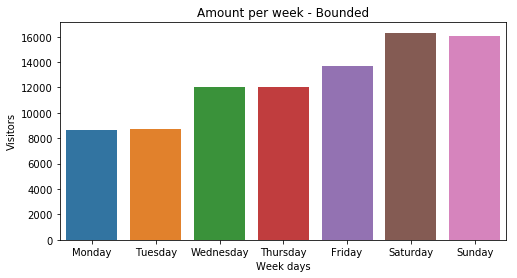

In [52]:
# Bar Plot 

# Set width and height
plt.figure(figsize = (8,4))
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Add title
plt.title("Amount per week - Bounded")
plt.xlabel("Week days")
plt.ylabel("Visitors")

sns.barplot(x = x , y = perDayAmountBounded)

In [53]:
#CAlculate Differentially private amount
def privatePerDayAmountBounded():
    x = dp.BoundedSum(epsilon, MIN_EUROS_SPENT, MAX_EUROS_SPENT )
    x.l0_sensitivity = 4
    return x.result(visitor_df["VisitorId","Money spent (euros)"])
    

privatePerDayAmountBounded()



AttributeError: 'pydp.pydp.BoundedSum' object has no attribute 'l0_sensitivity'

In [55]:
#Comparison graph

labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x1 = perDayAmountBounded
x2 = privatePerDayAmountBounded

comparison_graph(labels, x1, x2, 'perDayAmountBounded', 'privatePerDayAmountBounded', 'Visitors','Amount Spent Per Day VS Differentially private - Amount Spent Per Day'  )
